# Setup

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [1]:
!mamba  install  -q -y -c rapidsai -c conda-forge -c nvidia cucim cuml #cupy
!git clone https://github.com/danionella/hoffmann_et_al_2023.git
!pip install --ignore-installed  --quiet ./hoffmann_et_al_2023
!wget "https://owncloud.charite.de/owncloud/index.php/s/zc9NTVJMw8AiuQn/download?path=%2F&files=20230611_export_3.h5" -O data.h5

# Analysis

In [18]:
import h5py as h5
import numpy as np
import cupy as cp
from tqdm.auto import tqdm
from wholebrain import util,cluster,spatial,regression,stats
from functools import partialmethod
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.gridspec import GridSpec
# TURN TQDM ON/OFF
tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

In [9]:
def load_dset(name):
    with h5.File('./data.h5','r') as fh5:
        return fh5[name]['coords'][:],fh5[name]['dff'][:],fh5[name]['traces'][:]

In [10]:
data={}
with h5.File('./data.h5','r') as fh5:
    names=[n for n in fh5.keys()]
    print('Datasets:', names)

Datasets: ['dset_0', 'dset_1', 'dset_2', 'dset_3', 'dset_4', 'dset_5']


In [22]:
name=names[0]
n_repeats = 25
pred_list = [50,100,200,400,1000,2000]
voxel_size_list = [50,100,200]
metrics = ['similarity', 'distortion']

out = np.ones((len(names), len(metrics), len(pred_list), len(voxel_size_list), n_repeats, 2)) * np.nan
        
for k_ds, name in enumerate(tqdm(names, position=0, leave=True)):
    
    coords,dff,traces=load_dset(name)
    dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1))] # Centered Data without NANs ( motion)
   
   
    randperm = np.random.permutation(np.arange(len(coords)))
    dff_mu = dff_mu[:,randperm]
    coords = coords[randperm]


    cell_mask = np.zeros(len(coords), dtype='bool')
    cell_mask[::2] = True
    
    for k_metric, metric in enumerate(metrics):
        if metric == 'similarity':
            def distortion_stress(D0, D):
                return stats.pearsonr.gpu(D0.ravel(),D.ravel())[0]
            def distance_fun(x):
                return 1-stats.corrx.gpu(x.T,x.T)
        elif metric == 'distortion':
            def distortion_stress(D0, D):
                return spatial.distortion_stress(D0,D)
            def distance_fun(x):
                return spatial.pdist.gpu(x)
        
        D0 = distance_fun(dff_mu[:,cell_mask])

        for k_vx, voxel_size in enumerate(voxel_size_list):
            for k_pred, n_pred in enumerate(pred_list):
                for k in range(n_repeats):
                    cell_sub = dff_mu[:,np.random.choice(np.where(~cell_mask)[0], size=n_pred, replace=False)]
                    dd_cell = distortion_stress(D0,distance_fun(cell_sub))
                    vox_sub = spatial.voxelate(coords[~cell_mask] + np.random.rand(1,3)*voxel_size, dff_mu[:,~cell_mask], voxel_size, average=True)[0]
                    if vox_sub.shape[1] < n_pred: continue
                    vox_sub = vox_sub[:,np.random.choice(np.arange(vox_sub.shape[1]), size=n_pred, replace=False)]
                    dd_vox = distortion_stress(D0,distance_fun(vox_sub))
                    out[k_ds,k_metric,k_pred,k_vx,k,:] = [dd_cell, dd_vox]



100%|████████████████████████████████████████████████████████████| 6/6 [07:47<00:00, 77.86s/it]


(-0.5906639499614411,
 1.0349392632478638,
 -0.9646840142622274,
 0.5736122726850303)

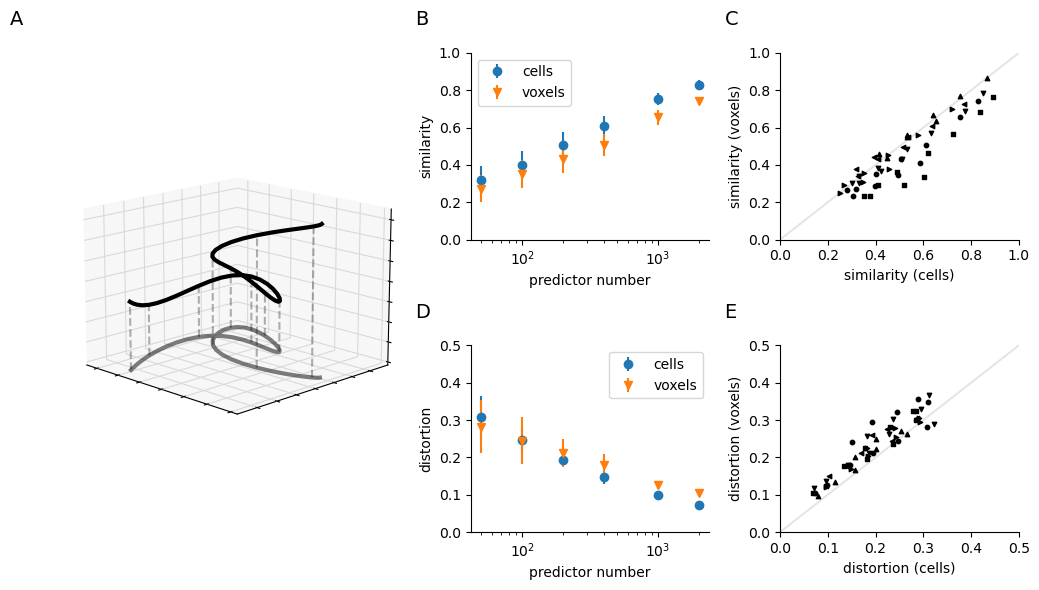

In [25]:

fig, axs = plt.subplot_mosaic("ABC;ADE", figsize=(10.5,6), width_ratios=[1.4,1,1])

trans = matplotlib.transforms.ScaledTranslation(-40/72, 20/72, fig.dpi_scale_trans)
for n, (key, ax) in enumerate(axs.items()):
    ax.text(0, 1, key, transform=ax.transAxes+trans, size=14, weight='regular')
sns.despine()

markers = ['o','v','^','<','>','s','*','+','x']

[axs[k].axis('off') for k in axs.keys() if k in ['A',]]

ylim = 1
axs['B'].errorbar(pred_list,out.mean(-2)[0,0,:,0,0], out.std(-2)[0,0,:,0,0],fmt='o', label='cells')
axs['B'].errorbar(pred_list,out.mean(-2)[0,0,:,0,1], out.std(-2)[0,0,:,0,1],fmt='v', label='voxels')
axs['B'].set(ylim=(0,ylim), xlabel='predictor number', ylabel=metrics[0], xscale='log')
axs['B'].legend()
for i in range(len(out)): 
     axs['C'].scatter(out.mean(-2)[i,0,...,0].ravel(), out.mean(-2)[i,0,...,1], marker=markers[i], color='k', s=10)
axs['C'].plot([0,ylim],[0,ylim], 'k', alpha=0.1)
axs['C'].set(xlim=(0,ylim), ylim=(0,ylim), xlabel=metrics[0]+' (cells)', ylabel=metrics[0]+' (voxels)')

ylim = 0.5
axs['D'].errorbar(pred_list,out.mean(-2)[0,1,:,0,0], out.std(-2)[0,1,:,0,0],fmt='o', label='cells')
axs['D'].errorbar(pred_list,out.mean(-2)[0,1,:,0,1], out.std(-2)[0,1,:,0,1],fmt='v', label='voxels')
axs['D'].set(ylim=(0,ylim), xlabel='predictor number', ylabel=metrics[1], xscale='log')
axs['D'].legend()
for i in range(len(out)): 
     axs['E'].scatter(out.mean(-2)[i,1,...,0].ravel(), out.mean(-2)[i,1,...,1],  marker=markers[i], color='k', s=10)
axs['E'].plot([0,ylim],[0,ylim], 'k', alpha=0.1)
axs['E'].set(xlim=(0,ylim), ylim=(0,ylim), xlabel=metrics[1]+' (cells)', ylabel=metrics[1]+' (voxels)')

fig.tight_layout()

import scipy
ss = axs['A'].get_subplotspec()
axs['A'] = fig.add_subplot(ss, projection='3d')
seed = 185 #np.random.randint(1000)
np.random.seed(seed)
r = np.random.randn(50,3)*2
rf = scipy.ndimage.gaussian_filter1d(r, 5, axis=0)
rf -= rf.mean(0)
axs['A'].plot(rf[:,0], rf[:,1], rf[:,2], 'k', linewidth=3)
axs['A'].plot(rf[:,0], rf[:,1], 'k', zs=-1, zdir='z', linewidth=3, alpha=0.5)
for i in range(0,len(rf),5):
    axs['A'].plot([rf[i,0], rf[i,0]], [rf[i,1], rf[i,1]], [-1, rf[i,2]], 'k--', alpha=0.3, linewidth=1.5)

for axis in [axs['A'].xaxis, axs['A'].yaxis, axs['A'].zaxis]:
    axis.set_ticklabels([])
    axis._axinfo['grid']['color'] = np.ones(3)*0.85
    axis.set_pane_color(np.ones(3)*0.97)

axs['A'].view_init(elev=15, azim=-45, roll=0)
axs['A'].axis('tight')

